# Visualizing Fire Scars through False Color
### EDS 220 Task 2

##### Author: Ava Robillard
##### [GitHub repository](https://github.com/avarobillard/eds220-hwk4)

### Purpose:

In this notebook a [false color image](https://earthobservatory.nasa.gov/features/FalseColor) is created using Landsat remote sensing data to highlight the locations of the Palisades Fire and Eaton Fire in Los Angeles County, California that occurred in early January 2025.

### Analysis highlights:

- Geospatial data exploration and wrangling with `geopandas`
- NetCDF data exploration and wrangling with `xarray` and `rioxarray`
- Creation of true color and false color images using Landsat bands
- Mapping of vector and raster data and customization with `matplotlib`

### About the data:

In this notebook we use two datasets:

**1) Fire perimeter data**

The data used to map the fire perimeters were retrieved as two shapefiles from the [City of Los Angeles GeoHub.](https://geohub.lacity.org/maps/ad51845ea5fb4eb483bc2a7c38b2370c/about) The layers contained dissolved fire perimeters in the form of polygons for the Eaton and Palisades fires. Each layer contained columns with an OBJECTID, type (Heat Perimeter), shape area and shape length, and a geometry column.

**2) Landsat 8 satellite data**

Landsat Collection 2 Level-2 atmospherically corrected surface reflectance data collected by the Landsat 8 satellite was used for this analysis, retrieved as a simplified collection of bands from the [Microsoft Planetary Computer data catalogue.](https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2) This data was then clipped to the area of interest surrounding the fire perimeters and used in the form of a NetCDF with the red, green, blue, near-infrared and shortwave infrared bands as variables.


### References:

City of Los Angeles. (2025). Palisades and Eaton Dissolved Fire Perimeters (2025) [GIS shapefiles]. Los Angeles GeoHub. Accessed November 20, 2025, from https://geohub.lacity.org/maps/ad51845ea5fb4eb483bc2a7c38b2370c/about

Microsoft Planetary Computer. (n.d.). Landsat Collection 2 Level‑2 [Dataset]. Microsoft. Accessed November 20, 2025, from https://planetarycomputer.microsoft.com/dataset/landsat‑c2‑l2 

In [41]:
# Load packages
import os
import pandas as pd
import numpy as np
import geopandas as gpd
import xarray as xr
import rioxarray 
import matplotlib.pyplot as plt

os.environ['PROJ_LIB'] = '/opt/anaconda3/share/proj'

### 1. Fire perimeter data exploration

In [42]:
# Import Palisades fire perimeter shapefile
fp = os.path.join('data', 'Palisades_Perimeter_20250121')
palisades_fire = gpd.read_file(fp)

# Import Eaton fire perimeter shapefile
fp = os.path.join('data', 'Eaton_Perimeter_20250121')
eaton_fire = gpd.read_file(fp)

In [43]:
# Display first few rows of Palisades fire data
palisades_fire.head()

,OBJECTID,type,Shape__Are,Shape__Len,geometry
0,1,Heat Perimeter,1182.082031,267.101144,"POLYGON ((-13193543.302 4032913.077, -13193543..."
1,2,Heat Perimeter,2222.488281,185.498783,"POLYGON ((-13193524.155 4033067.953, -13193524..."
2,3,Heat Perimeter,21.011719,22.412814,"POLYGON ((-13193598.085 4033158.222, -13193598..."
3,4,Heat Perimeter,214.992188,76.639180,"POLYGON ((-13193654.249 4033146.033, -13193656..."
4,5,Heat Perimeter,44203.453125,1569.259764,"POLYGON ((-13194209.580 4033236.320, -13194209..."


<Axes: >

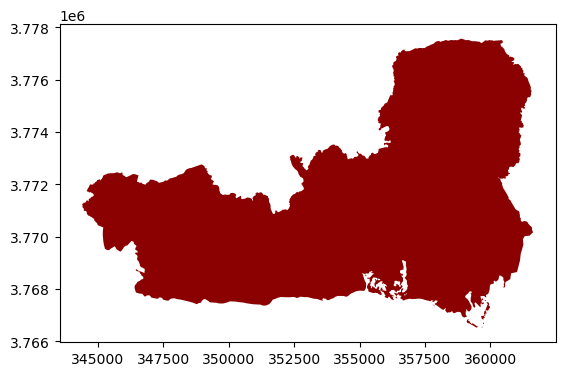

In [78]:
# Visualize fire perimeter
palisades_fire.plot(color = "darkred")

In [44]:
# Display first few rows of Eaton fire data
eaton_fire.head()

,OBJECTID,type,Shape__Are,Shape__Len,geometry
0,1,Heat Perimeter,2206.265625,270.199719,"POLYGON ((-13146936.686 4051222.067, -13146932..."
1,2,Heat Perimeter,20710.207031,839.204218,"POLYGON ((-13150835.463 4052713.929, -13150831..."
2,3,Heat Perimeter,3639.238281,250.304502,"POLYGON ((-13153094.697 4053057.596, -13153113..."
3,4,Heat Perimeter,1464.550781,148.106792,"POLYGON ((-13145097.740 4053118.235, -13145100..."
4,5,Heat Perimeter,4132.753906,247.960744,"POLYGON ((-13153131.126 4053196.882, -13153131..."


<Axes: >

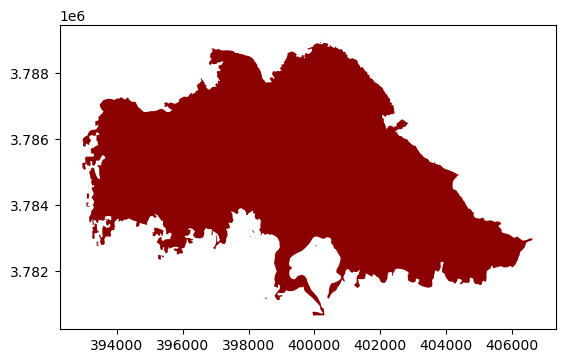

In [77]:
# Visualize fire perimeter
eaton_fire.plot(color = "darkred")

In [45]:
# Check the CRS
palisades_fire.crs

<Projected CRS: PROJCS["WGS_1984_Web_Mercator_Auxiliary_Sphere",GE ...>
Name: WGS_1984_Web_Mercator_Auxiliary_Sphere
Axis Info [cartesian]:
- [east]: Easting (Meter)
- [north]: Northing (Meter)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [46]:
# Examine CRS details
print('Ellipsoid:', palisades_fire.crs.ellipsoid)
print('Datum:', palisades_fire.crs.datum)
print('Is geographic?:', palisades_fire.crs.is_geographic)
print('Is projected?:', palisades_fire.crs.is_projected)

Ellipsoid: WGS 84
Datum: World Geodetic System 1984
Is geographic?: False
Is projected?: True


In [47]:
# Check that the CRS is the same for both fire perimeter data sets
palisades_fire.crs == eaton_fire.crs

True

The fire perimeter data is made up of polygons based on the geometry column. Both the Palisades and Eaton fire perimeter data have the same projected CRS, WGS 84.

### 2. NetCDF data import and exploration

In [48]:
# Import Landsat data as xarray.Dataset
fp = os.path.join('data', 'landsat8-2025-02-23-palisades-eaton.nc')

landsat = xr.open_dataset(fp)

In [49]:
# Explore dimensions, coordinates and data variables of Landsat data
landsat

<xarray.Dataset> Size: 78MB
Dimensions:      (y: 1418, x: 2742)
Coordinates:
  * y            (y) float64 11kB 3.799e+06 3.799e+06 ... 3.757e+06 3.757e+06
  * x            (x) float64 22kB 3.344e+05 3.344e+05 ... 4.166e+05 4.166e+05
    time         datetime64[ns] 8B ...
Data variables:
    red          (y, x) float32 16MB ...
    green        (y, x) float32 16MB ...
    blue         (y, x) float32 16MB ...
    nir08        (y, x) float32 16MB ...
    swir22       (y, x) float32 16MB ...
    spatial_ref  int64 8B ...

In [50]:
# Check the dimensions of the dataset
landsat.dims

FrozenMappingWarningOnValuesAccess({'y': 1418, 'x': 2742})

In [51]:
# Check the attributes of the red variable
landsat.red.attrs

{'grid_mapping': 'spatial_ref'}

In [52]:
# Check the attributes of the spatial_ref variable
landsat.spatial_ref.attrs

{'crs_wkt': 'PROJCS["WGS 84 / UTM zone 11N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-117],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32611"]]',
 'semi_major_axis': 6378137.0,
 'semi_minor_axis': 6356752.314245179,
 'inverse_flattening': 298.257223563,
 'reference_ellipsoid_name': 'WGS 84',
 'longitude_of_prime_meridian': 0.0,
 'prime_meridian_name': 'Greenwich',
 'geographic_crs_name': 'WGS 84',
 'horizontal_datum_name': 'World Geodetic System 1984',
 'projected_crs_name': 'WGS 84 / UTM zone 11N',
 'grid_mapping_name': 'tra

When looking at the landsat xarray.Dataset, we can see that the coordinates include x, y, time, and spatial_ref. The data variables are red, green, blue, nir08, and swir22. When checking the dimensions of the dataset, I found that there are 1418 pixels in the y direction and 2742 pixels in the x direction, which makes up each data variable/band (red, green, blue, etc.). I also checked the attributes of the red variable, which included its spatial_ref. The other data variables contain the same attribute. There were many coordinate attributes for spatial_ref, including crs_wkt which tells us that the CRS should be EPSG 32611. 

### 3. Restoring geospatial information

In [53]:
# Check CRS of landsat data
print(landsat.rio.crs)

None


`landsat` is not yet a geospatial object, but contains a CRS to apply.

In [54]:
# Print the CRS contained in the crs_wkt attribute of the spatial_ref variable
print(landsat.spatial_ref.crs_wkt)

PROJCS["WGS 84 / UTM zone 11N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-117],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32611"]]


In [55]:
# Recover geospatial information by setting CRS on landsat xarray.Dataset
landsat.rio.write_crs(32611, inplace=True)
landsat.rio.crs

ERROR 1: PROJ: proj_create_from_database: /opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: proj_identify: /opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


CRS.from_wkt('PROJCS["WGS 84 / UTM zone 11N",GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-117],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32611"]]')

In [59]:
# Reproject fire perimeter data to Landsat CRS
palisades_fire = palisades_fire.to_crs(landsat.rio.crs)
eaton_fire = eaton_fire.to_crs(landsat.rio.crs)

# Confirm changes
assert palisades_fire.crs == landsat.rio.crs
assert eaton_fire.crs == landsat.rio.crs

### 4. True color image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/opt/anaconda3/envs/eds220-env/lib/python3.11/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


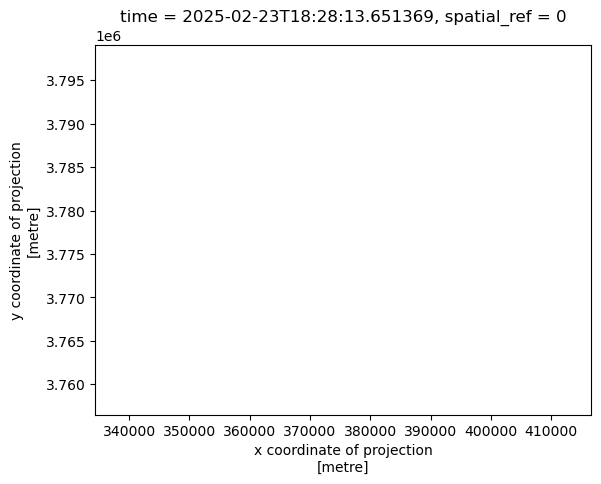

In [60]:
# Create RBG image with landsat variables
landsat[['red', 'green', 'blue']].to_array().plot.imshow()

In [61]:
# Identify which bands have NaN values using a list of the bands
for band in ['red', 'green', 'blue', 'nir08', 'swir22']:
    count = np.isnan(landsat[band].values).sum()
    print(f"There are {count} NaN values in the {band} band.")

There are 0 NaN values in the red band.
There are 1 NaN values in the green band.
There are 109 NaN values in the blue band.
There are 0 NaN values in the nir08 band.
There are 0 NaN values in the swir22 band.


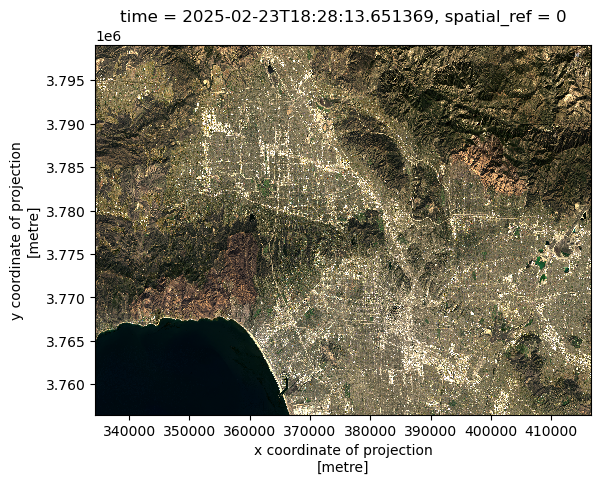

In [62]:
# Correct image with and substituted NaN values and adjusted scales
landsat[['red', 'green', 'blue']].to_array().fillna(0).plot.imshow(robust = True)

In the first image, errors are encountered and nothing appears to be plotted due to the scale of the data and NaN values not being the correct type. Using robust = True uses 2nd and 98th percentiles of data instead of absolute min and max to avoid extreme outliers like clouds to make the image visible, correcting the scale and clipping range issue. Filling the NaN values found mostly in the blue band with 0 allows the values to be correctly cast and plotted. The final true color image shows a visible range of the band values.

### 5. False color image

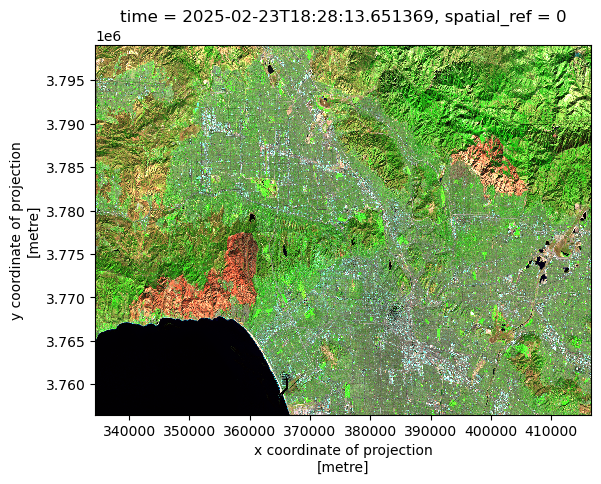

In [63]:
# Create false color image
landsat[['swir22', 'nir08', 'red']].to_array().fillna(0).plot.imshow(robust = True)

### 6. Map

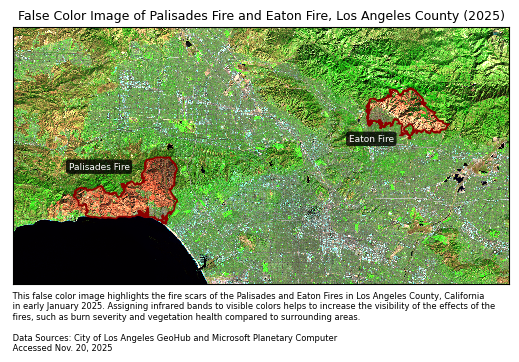

In [152]:
# Create map
fig, ax = plt.subplots()

landsat[['swir22', 'nir08', 'red']].to_array().fillna(0).plot.imshow(ax=ax, robust = True)

palisades_fire.plot(ax=ax,
                    color = "none",
                    edgecolor = "darkred",
                   linewidth = 1.2)

eaton_fire.plot(ax=ax,
               color = "none",
                edgecolor = "darkred",
                linewidth = 1.2)

ax.set_title("False Color Image of Palisades Fire and Eaton Fire, Los Angeles County (2025)",
            size = 9)

# Remove axes ticks
ax.set_xticks([])
ax.set_yticks([])

# Remove axes labels
ax.set_xlabel("")  
ax.set_ylabel("")  

# Add fire names as text annotations

ax.text(palisades_fire.geometry.centroid.iloc[0].x - 6000,
        palisades_fire.geometry.centroid.iloc[0].y + 9000,
        "Palisades Fire",
        color = "white",
        fontsize = 6.5,
        ha = 'right',
        bbox = dict(facecolor='black', alpha=0.8, edgecolor='none', pad=2, boxstyle="round,pad=0.3"))

ax.text(eaton_fire.geometry.centroid.iloc[0].x - 1000,
        eaton_fire.geometry.centroid.iloc[0].y - 1000,
        "Eaton Fire",
        color = 'white',
        fontsize = 6.5,
        ha = 'right',
        bbox = dict(facecolor='black', alpha=0.8, edgecolor='none', pad=2, boxstyle="round,pad=0.3"))

plt.figtext(0.12, 0.09, " This false color image highlights the fire scars of the Palisades and Eaton Fires in Los Angeles County, California \n in early January 2025. Assigning infrared bands to visible colors helps to increase the visibility of the effects of the \n fires, such as burn severity and vegetation health compared to surrounding areas.\n \n Data Sources: City of Los Angeles GeoHub and Microsoft Planetary Computer \n Accessed Nov. 20, 2025", fontsize = 6)

plt.show()